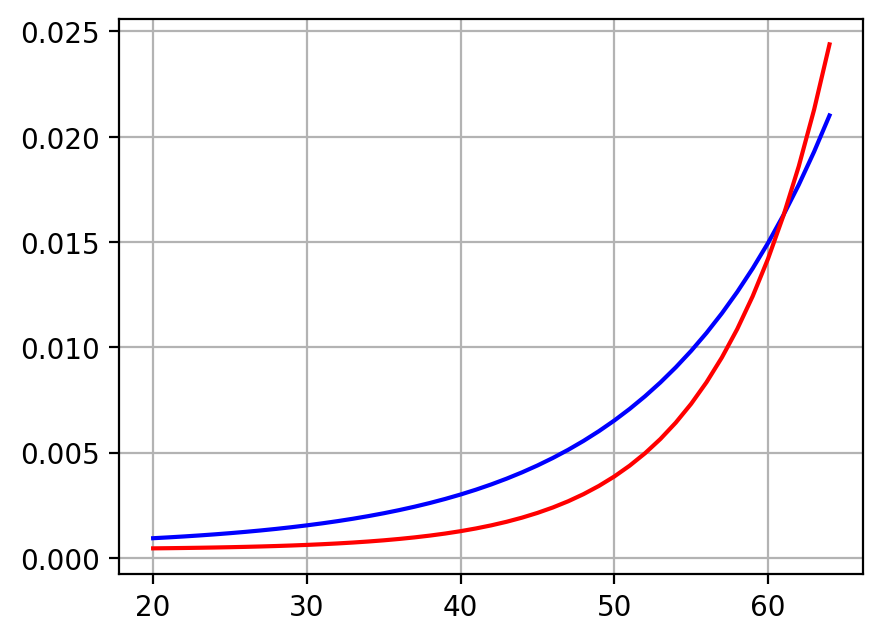

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Markov:
    def __init__(self):
        self.iNrStates = None
        self.iMaxTime  = None    
        self.dPij = []
        self.dPre = []
        self.dPost= []
        self.dv   = []
        self.dDK  = []
        self.dCF  = []
        self.bCalculated = False
        self.bCFCalculated = False
        self.iStart = None
        self.iStop  = None
    
    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        for i in range(iMaxTime):
            tempPij = np.zeros([iNrStates,iNrStates])
            tempPost = np.zeros([iNrStates,iNrStates])
            tempPre = np.zeros([iNrStates])
            tempDK = np.zeros([iNrStates])
            tempCF = np.zeros([iNrStates])
            self.dPij.append(tempPij)
            self.dPost.append(tempPost)
            self.dPre.append(tempPre)
            self.dDK.append(tempDK)
            self.dCF.append(tempCF)         
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
    
    def vSetDiscount(self,fIRate):
        vTemp = 1./(1.+fIRate)
        print("Discount %.4f"%(vTemp))
        for i in range(self.iMaxTime):
            self.dv[i] = vTemp
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPij(self,t,i,j,fValue):
        self.dPij[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPre(self,t,i,j,fValue):
        self.dPre[t][i] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPost(self,t,i,j,fValue):
        self.dPost[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    
    def doCalculateDK(self,iStart,iStop,iAge,iState):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
        
        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])
    
    def doCalculateCF(self,iStart,iStop,iAge,iState,bTrace=False):
        self.iStop = iStop
        self.iStart = iStart
        self.bCFCalculated = True
        for i in range(self.iMaxTime):
            self.dCF[i] *= 0.
        
        CurrentP = np.mat(np.identity(self.iNrStates))
        if bTrace:
            print("----- ----- ----- ----- ")
        for i in range(self.iStop, self.iStart):
            if bTrace:
                print("----- ----- ----- ----- ")
                print(" Time ", i)
                print("CF BoP", self.dCF[i])
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    self.dCF[i][k] += CurrentP[k,l] * self.dPre[i][l]
            if bTrace:
                print("CF BoP after Pre", self.dCF[i])
            NextP = np.mat(self.dPij[i])
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
                print("Next P\n", NextP) 
                print("+++++ +++++ +++++ ")
                
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    for m in range(self.iNrStates):
                        self.dCF[i+1][k] += CurrentP[k,l] * NextP[l,m] * self.dPost[i][l,m]
            if bTrace:
                print("CF EoP t", self.dCF[i])
                print("CF EoP t+1", self.dCF[i+1])
            
            CurrentP = CurrentP * NextP
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP EoP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
    
    def dGetDK(self,iStart,iStop,iAge,iState):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])

    def dGetCF(self,iStart,iStop,iAge,iState):
        if (not(self.bCFCalculated) or self.iStart != iStart or self.iStop != iStop ):
            self.doCalculateCF(iStart,iStop,iAge,iState)
        return(self.dCF[iAge][iState])
    
    def PrintDKs(self,iStart,iStop):
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            for j in range(self.iNrStates):
                 strTemp += "   %10.4f  "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
    
    def PlotDKs(self,iStart,iStop,figNr=1):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)
        
    def PlotCFs(self,iStart,iStop,figNr=2):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetCF(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)

                 
def mu(t):
    return(0.0005+10**(0.038*t-4.12))

def sigma(t):
    return(0.0004+10**(0.06*t-5.46))

x=[]
qx=[]
ix=[]
for i in range(20,65):
    x.append(i)
    qx.append(mu(i))
    ix.append(sigma(i))
    
plt.figure(1)
plt.plot(x,qx,'b',x,ix,'r')
plt.grid(True)

Discount 0.9615
Discount 0.9615
Discount 0.9615
Premium w/o waiver 214.166796 w waiver 218.058537


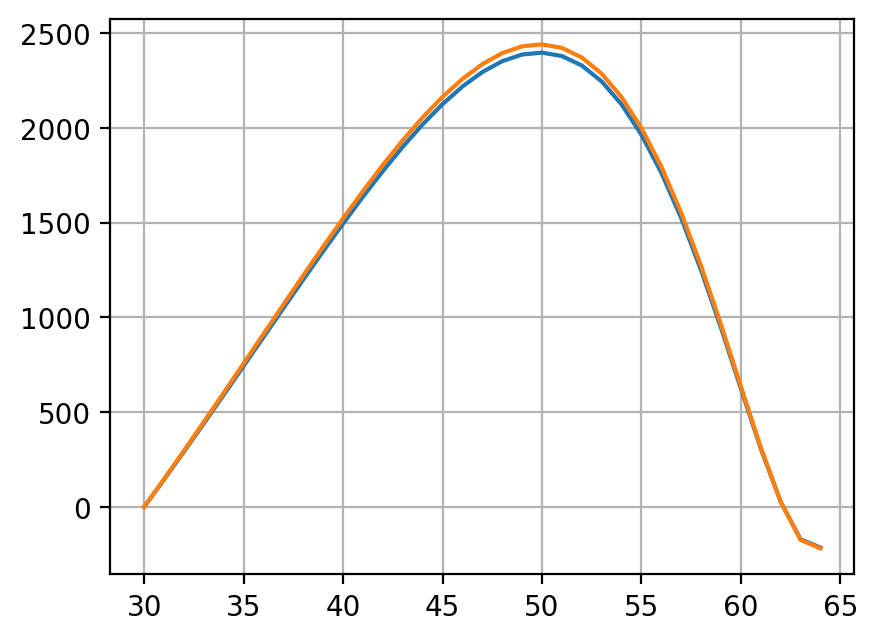

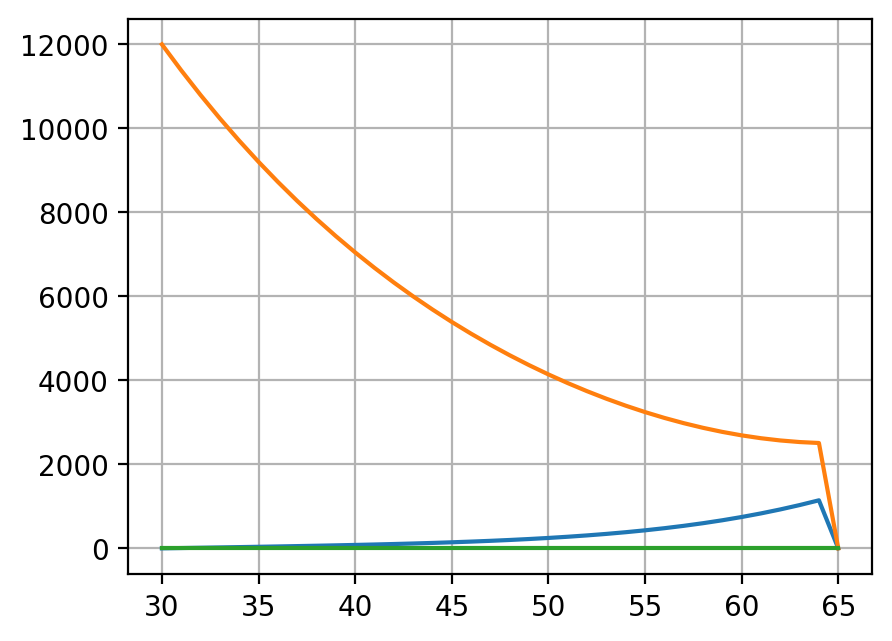

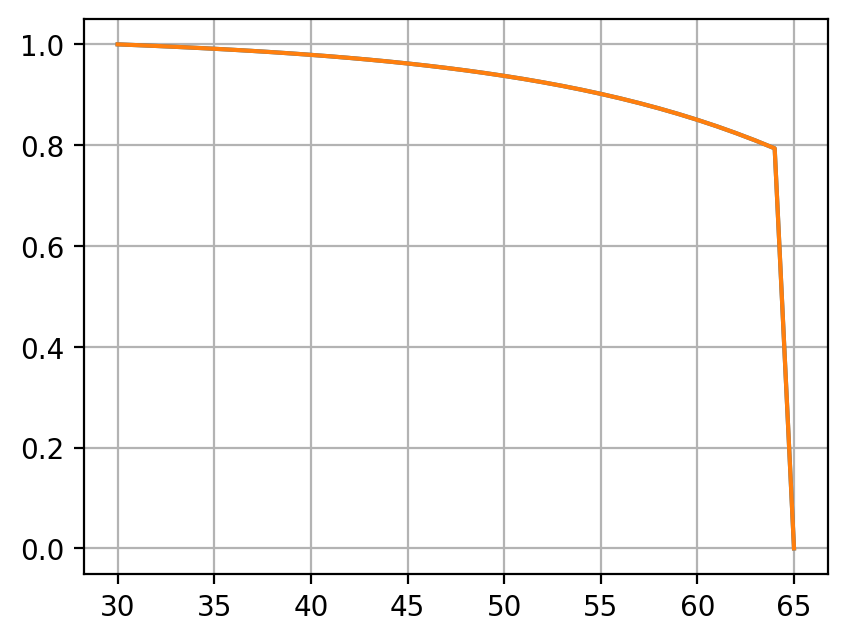

In [2]:
symMB = Markov()
symMB.vDefineModel(3)
symMB.vSetDiscount(0.04)

symMP = Markov()
symMP.vDefineModel(2)
symMP.vSetDiscount(0.04)

symMPW = Markov()
symMPW.vDefineModel(2)
symMPW.vSetDiscount(0.04)

ObjVector =[]
ObjVector.append(symMB)
ObjVector.append(symMP)
ObjVector.append(symMPW)



iStart = 65
iStop = 30
Annuity = 12000

for i in range(iStop,iStart):
    qx = mu(i)
    ix = sigma(i)
    rx = 0.05
    for myobj in ObjVector:
        myobj.vSetPij(i,0,0,1-qx-ix)
        myobj.vSetPij(i,0,1,ix)
    #myobj.vSetPij(i,0,2,qx)
        myobj.vSetPij(i,1,0,rx)
        myobj.vSetPij(i,1,1,1.-rx-qx)
    #myobj.vSetPij(i,1,2,qx)
    
for i in range(iStop,iStart):
    symMB.vSetPre(i,1,1,Annuity)
    symMP.vSetPre(i,0,0,1)
    symMP.vSetPre(i,1,1,1)
    symMPW.vSetPre(i,0,0,1)



PP = symMB.dGetDK(iStart,iStop,iStop,0)/symMP.dGetDK(iStart,iStop,iStop,0)
PPW = symMB.dGetDK(iStart,iStop,iStop,0)/symMPW.dGetDK(iStart,iStop,iStop,0)

print("Premium w/o waiver %f w waiver %f"%(PP, PPW))

x=[]
y1=[]
y2=[]

for i in range(iStop,iStart):
    x.append(i)
    y1.append(symMB.dGetDK(iStart,iStop,i,0)- PP *symMP.dGetDK(iStart,iStop,i,0))
    y2.append(symMB.dGetDK(iStart,iStop,i,0)- PPW *symMPW.dGetDK(iStart,iStop,i,0))
    
plt.figure(1)
plt.plot(x,y1,x,y2)
plt.grid(True)

symMB.PlotCFs(iStart,iStop,figNr=2)
symMP.PlotCFs(iStart,iStop,figNr=3)